# Random Forest 모델 구축
    1. 데이터 전처리
    2. Random Forest 모델 구축
        K-Fold cross validation 활용
    3. 예측 결과 평가 및 중요 변수 산출

## 1. 모듈 불러오기

In [29]:
from IPython.display import display, HTML
import warnings
warnings.filterwarnings(action = 'ignore')

from sklearn.datasets import load_breast_cancer, load_boston

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, recall_score, precision_score, mean_squared_error, mean_absolute_error, r2_score, plot_confusion_matrix

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
matplotlib.rcParams['axes.unicode_minus'] = False

plt.rc('font', family = 'Malgun Gothic')

## 2. 데이터 불러오기

### 반응변수
    * diagnosis : 양성여부 ( Maligant = 1 악성(유방암), Benign = 0 양성(단순낭종) )

In [7]:
breast_cancer = load_breast_cancer()
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [12]:
breast_cancer.data.shape

(569, 30)

## 3. 탐색적 데이터 분석 및 데이터 전처리

In [13]:
X = pd.DataFrame(breast_cancer.data, columns = breast_cancer.feature_names)
y = pd.DataFrame(breast_cancer.target, columns = ['diagnosis'])

In [14]:
X[:5]

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [15]:
y[:5]

,diagnosis
0,0
1,0
2,0
3,0
4,0


### 결측치, 데이터 타입 확인

In [17]:
X.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [18]:
y.value_counts()

diagnosis
1            357
0            212
dtype: int64

### Train/Test 데이터 분리

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 2021)

normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

print(f'Train set dimension is {X_train.shape}')
print(f'Test set dimension is {X_test.shape}')

Train set dimension is (398, 30)
Test set dimension is (171, 30)


## 4. 모델링

### 4.1 단순 모델링 (사용자가 하이퍼파라미터 정의)

In [26]:
rfc = RandomForestClassifier(n_estimators = 10, random_state = 2021)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=2021)

In [27]:
# Train set에 대한 성능
y_pred = rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred = y_pred)
print('Train set에 대한 성능')
print(f'정확도:{acc:0.4f}')

# Test set에 대한 성능
y_pred = rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred = y_pred)
print('\n')
print('Test set에 대한 성능')
print(f'정확도:{acc:0.4f}')

Train set에 대한 성능
정확도:0.9950


Test set에 대한 성능
정확도:0.9415


### 4.2 단일 하이퍼파라미터에 대한 Grid Search

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.11it/s]


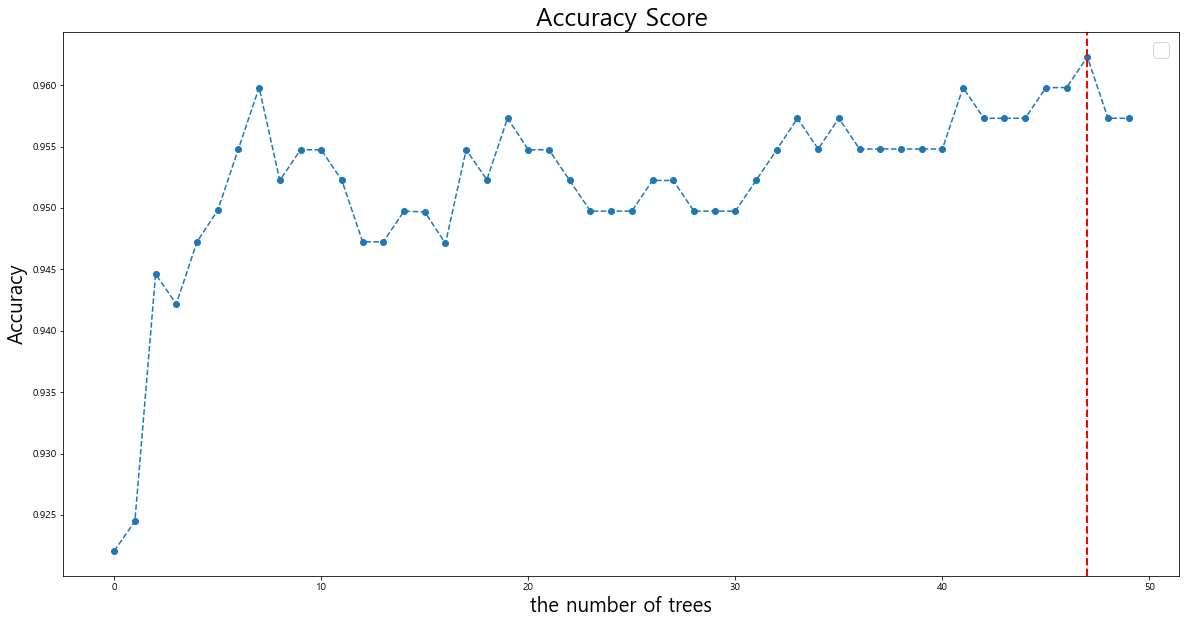

In [31]:
cv_scores = []
estimator_list = [i for i in range(0, 50, 1)]
for i in tqdm(range(0, 50, 1)):
    rfc = RandomForestClassifier(n_estimators = i+1, n_jobs = -1, random_state = 2021)
    score = cross_val_score(rfc, X_train, y_train, cv = 10, scoring = 'accuracy').mean()
    cv_scores.append(score)
    
best_e = [estimator_list[i] for i in range(len(cv_scores)) if cv_scores[i] == np.max(cv_scores)]
plt.figure(figsize = (20, 10))
plt.legend(['Cross validation scores'], fontsize = 20)
plt.plot(estimator_list, cv_scores, marker = 'o', linestyle = 'dashed')
plt.xlabel('the number of trees', fontsize = 20)
plt.ylabel('Accuracy', fontsize = 20)
plt.title('Accuracy Score', fontsize = 25)
plt.axvline(best_e[0], color = 'r', linestyle = '--', linewidth = 2)
plt.show()

In [32]:
print(f'최적의 tree개수:{(cv_scores.index(max(cv_scores)))+1}')
print('\n')
print('Train set에 대한 성능 (10 fold cross validation)')
print(f'정확도:{max(cv_scores):0.4f}')

최적의 tree개수:48


Train set에 대한 성능 (10 fold cross validation)
정확도:0.9623


In [33]:
rfc = RandomForestClassifier(n_estimators = 48, n_jobs = 1, random_state = 2021)
rfc.fit(X_train, y_train)

# Train set에 대한 성능
y_pred = rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred = y_pred)
print('Train set에 대한 성능')
print(f'정확도:{acc:0.4f}')

# Test set에 대한 성능
y_pred = rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred = y_pred)
print('\n')
print('Test set에 대한 성능')
print(f'정확도:{acc:0.4f}')

Train set에 대한 성능
정확도:1.0000


Test set에 대한 성능
정확도:0.9532


## 4.3 전체 하이퍼 파라미터에 대한 Grid Search

In [36]:
rfc = RandomForestClassifier(random_state = 2021)
param_grid = {
    'n_estimators' : [50, 60, 70],
    'max_depth' : [10, 15, 20],
    'max_leaf_nodes' : [50, 100, 200],
    'criterion' : ['gini', 'entropy'],
    'max_features' : ['auto', 'sqrt', 'log2']
}
CV_rfc = GridSearchCV(estimator = rfc, param_grid = param_grid, cv = 10, verbose = 1, n_jobs = 12)
CV_rfc.fit(X_train, y_train)

Fitting 10 folds for each of 162 candidates, totalling 1620 fits


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=2021),
             n_jobs=12,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 15, 20],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'max_leaf_nodes': [50, 100, 200],
                         'n_estimators': [50, 60, 70]},
             verbose=1)

In [38]:
# 최적의 하이퍼파라미터 셋
CV_rfc.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'max_leaf_nodes': 50,
 'n_estimators': 50}

In [42]:
result_table = pd.DataFrame(CV_rfc.cv_results_)
result_table = result_table.sort_values(by = 'mean_test_score', ascending = False)
print(result_table[['params', 'mean_test_score']])


                                                params  mean_test_score
81   {'criterion': 'entropy', 'max_depth': 10, 'max...         0.969808
141  {'criterion': 'entropy', 'max_depth': 20, 'max...         0.969808
114  {'criterion': 'entropy', 'max_depth': 15, 'max...         0.969808
117  {'criterion': 'entropy', 'max_depth': 15, 'max...         0.969808
108  {'criterion': 'entropy', 'max_depth': 15, 'max...         0.969808
..                                                 ...              ...
156  {'criterion': 'entropy', 'max_depth': 20, 'max...         0.954808
102  {'criterion': 'entropy', 'max_depth': 10, 'max...         0.954808
159  {'criterion': 'entropy', 'max_depth': 20, 'max...         0.954808
132  {'criterion': 'entropy', 'max_depth': 15, 'max...         0.954808
105  {'criterion': 'entropy', 'max_depth': 10, 'max...         0.954808

[162 rows x 2 columns]


In [43]:
best_rfc = CV_rfc.best_estimator_
best_rfc.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, max_leaf_nodes=50,
                       n_estimators=50, random_state=2021)

In [44]:
# Train set에 대한 성능
y_pred = best_rfc.predict(X_train)
acc = accuracy_score(y_true = y_train, y_pred = y_pred)
print('Train set에 대한 성능')
print(f'정확도:{acc:0.4f}')

# Test set에 대한 성능
y_pred = best_rfc.predict(X_test)
acc = accuracy_score(y_true = y_test, y_pred = y_pred)
print('\n')
print('Test set에 대한 성능')
print(f'정확도:{acc:0.4f}')

Train set에 대한 성능
정확도:1.0000


Test set에 대한 성능
정확도:0.9591


In [45]:
recall = recall_score(y_true = y_test, y_pred = y_pred)
precision = precision_score(y_true = y_test, y_pred = y_pred)

print(f"정확도 : {acc:0.4f}", f"민감도:{recall:0.4f}", f"정밀도:{precision:0.4f}", sep = '  |  ')

정확도 : 0.9591  |  민감도:0.9813  |  정밀도:0.9545


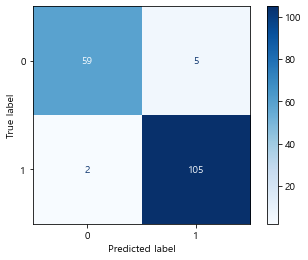

In [46]:
plot_confusion_matrix(best_rfc, X_test, y_test, cmap = plt.cm.Blues)
plt.show()

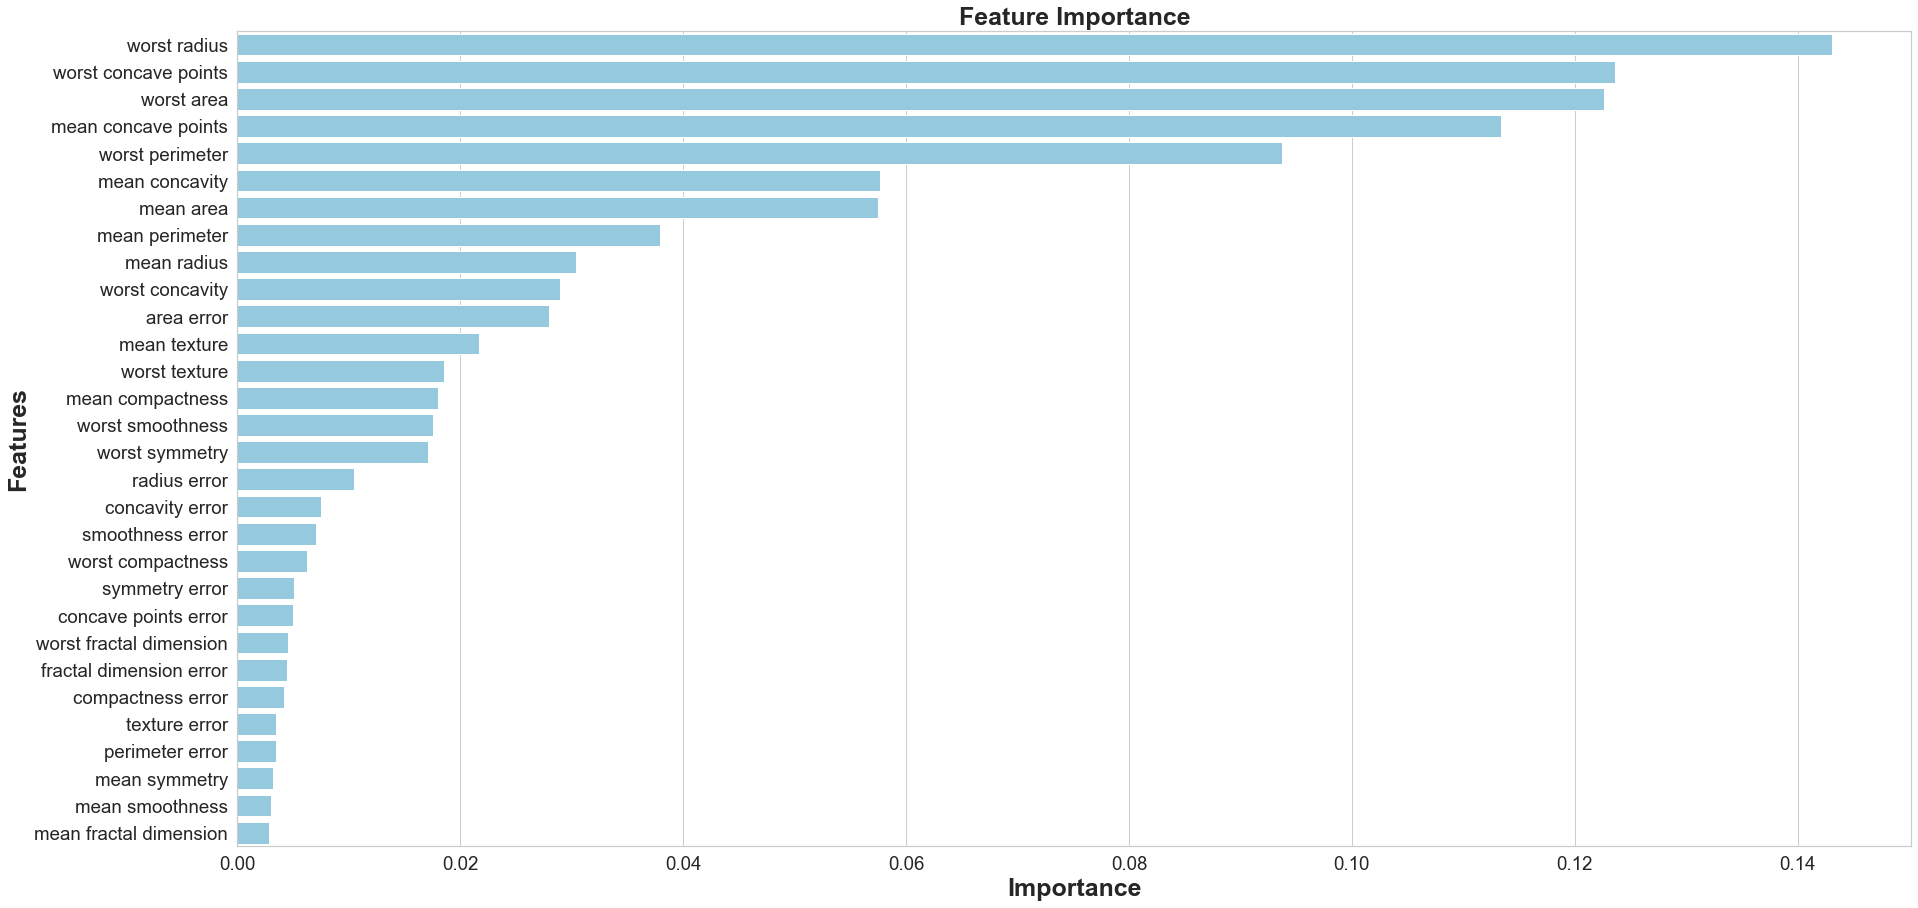

None

,Feature,Gini-Importance
0,worst radius,0.143055
1,worst concave points,0.123615
2,worst area,0.122636
3,mean concave points,0.113337
4,worst perimeter,0.093732
5,mean concavity,0.057639
6,mean area,0.057491
7,mean perimeter,0.037944
8,mean radius,0.030411
9,worst concavity,0.028909


In [52]:
feats = {}
for feature, importance in zip(breast_cancer.feature_names, best_rfc.feature_importances_):
    feats[feature] = importance
importances = pd.DataFrame.from_dict(feats, orient = 'index').rename(columns = {0 : 'Gini-Importance'})
importances = importances.sort_values(by = 'Gini-Importance', ascending = False)
importances = importances.reset_index()
importances = importances.rename(columns = {'index' : 'Feature'})
sns.set(font_scale = 5)
sns.set(style = 'whitegrid', color_codes = True, font_scale = 1.7)
fig, ax = plt.subplots()
fig.set_size_inches(30, 15)
sns.barplot(x = importances['Gini-Importance'], y = importances['Feature'], data = importances, color = 'skyblue')
plt.xlabel('Importance', fontsize = 25, weight = 'bold')
plt.ylabel('Features', fontsize = 25, weight = 'bold')
plt.title('Feature Importance', fontsize = 25, weight = 'bold')
display(plt.show())
display(importances)

## 4.4 타 알고리즘과의 비교

In [56]:
# KNN
clasfifier = KNeighborsClassifier(n_neighbors = 5, p = 2)
clasfifier.fit(X_train, y_train)
y_pred = clasfifier.predict(X_test)

acc = accuracy_score(y_true = y_test, y_pred = y_pred)
recall = recall_score(y_true = y_test, y_pred = y_pred)
precision = precision_score(y_true = y_test, y_pred = y_pred)

print('KNN')
print(f"정확도 : {acc:0.4f}", f"민감도:{recall:0.4f}", f"정밀도:{precision:0.4f}", sep = '  |  ')

KNN
정확도 : 0.9474  |  민감도:0.9720  |  정밀도:0.9455


In [58]:
# DT
classifier = DecisionTreeClassifier(random_state = 2021)
param_grid = {
    'max_depth' : [10, 15, 20],
    'max_leaf_nodes' : [50, 100, 200],
    'criterion' : ['gini', 'entropy']
}
    
CV_classifier = GridSearchCV(estimator = classifier, param_grid = param_grid, cv = 10, verbose = 1, n_jobs = 12)
CV_classifier.fit(X_train, y_train)

best_classifier = CV_classifier.best_estimator_
best_classifier.fit(X_train, y_train)

y_pred = best_classifier.predict(X_test)

acc = accuracy_score(y_true = y_test, y_pred = y_pred)
recall = recall_score(y_true = y_test, y_pred = y_pred)
precision = precision_score(y_true = y_test, y_pred = y_pred)

print('DT')
print(f"정확도 : {acc:0.4f}", f"민감도:{recall:0.4f}", f"정밀도:{precision:0.4f}", sep = '  |  ')

Fitting 10 folds for each of 18 candidates, totalling 180 fits
DT
정확도 : 0.9591  |  민감도:0.9720  |  정밀도:0.9630


RF
    정확도 : 0.9591  |  민감도:0.9813  |  정밀도:0.9545<br></br>
KNN
    정확도 : 0.9474  |  민감도:0.9720  |  정밀도:0.9455<br></br>
DT
    정확도 : 0.9591  |  민감도:0.9720  |  정밀도:0.9630


## Regression

In [60]:
boston = load_boston()

X = boston.data
y = boston.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state = 2021)

rfr = RandomForestRegressor(random_state = 2021)
param_grid = {
    'max_depth' : [10, 50, 100, 200],
    'max_leaf_nodes' : [50, 100, 200],
    'criterion' : ['mae', 'mse']
}

CV_rfr = GridSearchCV(estimator = rfr, param_grid = param_grid, cv = 10, verbose = 1, n_jobs = 12, scoring = 'r2')
CV_rfr.fit(X_train, y_train)

best_rfr = CV_rfr.best_estimator_
best_rfr.fit(X_train, y_train)

y_pred = best_rfr.predict(X_test)

r2score = r2_score(y_true = y_test, y_pred = y_pred)
mse = mean_squared_error(y_true = y_test, y_pred = y_pred)
mae = mean_absolute_error(y_true = y_test, y_pred = y_pred)

print('Random Forest Regressor')
print(f"R2 score : {r2score:0.4f}", f"MSE:{mse:0.4f}", f"MAE:{mae:0.4f}", sep = '  |  ')

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Random Forest Regressor
R2 score : 0.8118  |  MSE:12.2319  |  MAE:2.2402


In [61]:
# DT Regressor
dtr = DecisionTreeRegressor(random_state = 2021)
param_grid = {
    'max_depth' : [10, 50, 100, 200],
    'max_leaf_nodes' : [50, 100, 200],
    'criterion' : ['mae', 'mse']
}

CV_dtr = GridSearchCV(estimator = dtr, param_grid = param_grid, cv = 10, verbose = 1, n_jobs = 12, scoring = 'r2')
CV_dtr.fit(X_train, y_train)

best_dtr = CV_dtr.best_estimator_
best_dtr.fit(X_train, y_train)

y_pred = best_dtr.predict(X_test)

r2score = r2_score(y_true = y_test, y_pred = y_pred)
mse = mean_squared_error(y_true = y_test, y_pred = y_pred)
mae = mean_absolute_error(y_true = y_test, y_pred = y_pred)

print('Random Forest Regressor')
print(f"R2 score : {r2score:0.4f}", f"MSE:{mse:0.4f}", f"MAE:{mae:0.4f}", sep = '  |  ')

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Random Forest Regressor
R2 score : 0.5741  |  MSE:27.6814  |  MAE:3.1224
